In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [2]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from keras.layers import Add
from keras.layers import Input
from keras.models import Model
from keras.layers import Flatten

Using TensorFlow backend.


In [3]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [4]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy.misc import imresize
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
from keras.utils import np_utils
from keras.models import Sequential

In [5]:
x_train = np.load("train_images_256_128.npy")
y_train = np.load("train_labels_256_128.npy")
x_test = np.load("test_images_256_128.npy")
y_test = np.load("test_labels_256_128.npy")

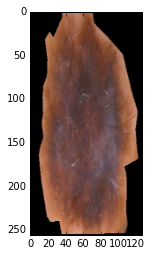

In [6]:
plt.imshow(x_train[1400])

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [9]:
#Initial convolutional block it will be common for all WRN-D-K networks
def initial_conv(Input):
    x = Conv2D(16,kernel_size=(3,3),strides = (1,1),padding = 'same')(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [10]:
#Expand Convolutional block having extra convolutional layer in Identity side

"""
Conv_no : Used to increase the depth of the network according to corresponding conv block
Stride : Used for Downsampling of Image
Dropout : Adds dropout if it is greater than 0.0

"""
def expand_conv(Input, k=1, conv_no = 1,stride=1,dropout =0.0):
    Initial = Input
    x = Conv2D(32*k*conv_no,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0):
        x = Dropout(dropout)(x)
    x = Conv2D(32*k*conv_no,kernel_size=(3,3),strides = (1,1),padding ='same')(x)
    skip = Conv2D(32*k*conv_no,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(Input)
    output = Add()([x,skip])
    return output

In [11]:
#First Convolutional Block 
#Input size = 32*32*N

"""
K : To Control the depth of residual network
Stride : Used for Downsampling of Image
Dropout : Adds dropout if it is greater than 0.0

"""
def conv_block1(Input, k = 1, stride = 1, dropout = 0.0):
    Initial = Input 
    x = BatchNormalization()(Input)
    x = Activation('relu')(x)
    x = Conv2D(32*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    x = Conv2D(32*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    output = Add()([x,Initial])
    return output

In [12]:
#Second Convolutional Block 
#Input size = 16*16*N

"""
K : To Control the depth of residual network
Stride : Used for Downsampling of Image
Dropout : Adds dropout if it is greater than 0.0

"""
def conv_block2(Input, k = 1, stride = 1, dropout = 0.0):
    Initial = Input 
    x = BatchNormalization()(Input)
    x = Activation('relu')(x)
    x = Conv2D(64*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    x = Conv2D(64*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    output = Add()([x,Initial])
    return output

In [13]:
#Third Convolutional Block 
#Input size = 8*8*N

"""
K : To Control the depth of residual network
Stride : Used for Downsampling of Image
Dropout : Adds dropout if it is greater than 0.0

"""
def conv_block3(Input, k = 1, stride = 1, dropout = 0.0):
    Initial = Input 
    x = BatchNormalization()(Input)
    x = Activation('relu')(x)
    x = Conv2D(128*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    x = Conv2D(128*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    output = Add()([x,Initial])
    return output


In [14]:
"""
Creates Wide Residual network with given parameters

height = height of the Image
width = width of the Image
K = Width of the network(will be multiplied)
depth = No of convolutional layers

"""
def create_wide_residual_network(height,width,k,depth):
    
    
    """
    n = depth of the network
    Depth of the network. n = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
              
    """
    n = (depth-4)/6
    
    #Input tensor
    inputs = Input(shape = (height,width,3), name = "image_input")
    
    #Initial Conv block
    x = initial_conv(inputs)
    
    #First Expansion block
    x = expand_conv(x,k,1,1,0.3)
    
    #First Convolutional Block
    #Depth depends on n
    for i in range(n-1):
        x = conv_block1(x,k,1,0.3)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Second Expansion Block
    x = expand_conv(x,k,2,2,0.3)
    
    
    #Second Convolutional Block
    #Depth depends on n
    for i in range(n-1):
        x = conv_block2(x,k,1,0.3)
        
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    
    #Third Expansion Block
    x = expand_conv(x,k,4,2,0.3)
    
    #Third Convolutional Block 
    #Depth depends on n
    for i in range(n-1):
        x = conv_block3(x,k,1,0.3)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Avg pooling to get 1*1 feature vectors
    x = AveragePooling2D(pool_size=(8,8))(x)
    x = Flatten()(x)
    
    #Classification Layer
    x = Dense(1,activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

In [15]:
#Used to create Model by calling above method
#WRN-16-8
model = create_wide_residual_network(256,128,4,16)

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 128, 16)  448                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 256, 128, 16)  64                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 256, 128, 16)  0                                            
___________________________________________________________________________________________

In [17]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [18]:
model.compile(loss='binary_crossentropy',
        optimizer="Adam",
        metrics=['accuracy'])

In [19]:
class_weights

array([ 0.6147541 ,  2.67857143])

In [42]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('wrn_classification_lr_e2_bs8_class_weights2.csv')
model_chekpoint = ModelCheckpoint("wrn_classification_lr_e2_bs8_class_weights2.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [43]:
batch_size = 16
data_augmentation = False
epochs = 50

In [ ]:
if data_augmentation :
    print("-------------Using Data augmentation------------")
     # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    datagen.fit(x_train)
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=20,verbose=1,validation_data=(x_test,y_test))
    
else :
    print("-----Not Using Data augmentation---------------")
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger,model_chekpoint], class_weight = class_weights)

-----Not Using Data augmentation---------------
Train on 1500 samples, validate on 500 samples
Epoch 1/50
1500/1500 [==============================] - 8580s - loss: 0.5738 - acc: 0.7693 - val_loss: 1.3919 - val_acc: 0.7580
Epoch 2/50
1500/1500 [==============================] - 11408s - loss: 0.5016 - acc: 0.8027 - val_loss: 0.5507 - val_acc: 0.8120
Epoch 3/50
1500/1500 [==============================] - 11407s - loss: 0.5000 - acc: 0.7913 - val_loss: 0.6687 - val_acc: 0.7140
Epoch 4/50
1500/1500 [==============================] - 11449s - loss: 0.4787 - acc: 0.8087 - val_loss: 0.4747 - val_acc: 0.8080
Epoch 5/50
1500/1500 [==============================] - 11505s - loss: 0.4610 - acc: 0.8153 - val_loss: 0.5777 - val_acc: 0.8060
Epoch 6/50
1500/1500 [==============================] - 11474s - loss: 0.4594 - acc: 0.8147 - val_loss: 0.5233 - val_acc: 0.7740
Epoch 7/50
1500/1500 [==============================] - 11428s - loss: 0.4670 - acc: 0.8200 - val_loss: 0.4670 - val_acc: 0.8080
Epo

In [20]:
model.load_weights('wrn_classification_lr_e2_bs8_class_weights.hdf5')

In [21]:
predictions = model.predict(x_test)

In [23]:
predictions = [[ 0.55323869],
       [ 0.40215158],
       [ 0.43898502],
       [ 0.34188187],
       [ 0.6056754 ],
       [ 0.22595276],
       [ 0.32237014],
       [ 0.24144724],
       [ 0.48808292],
       [ 0.4518387 ],
       [ 0.15628779],
       [ 0.61012834],
       [ 0.26439732],
       [ 0.13191937],
       [ 0.50522119],
       [ 0.51199371],
       [ 0.306115  ],
       [ 0.71107256],
       [ 0.46011984],
       [ 0.70410556],
       [ 0.32467753],
       [ 0.18108051],
       [ 0.1567748 ],
       [ 0.05994237],
       [ 0.6667186 ],
       [ 0.16527455],
       [ 0.21899581],
       [ 0.4020004 ],
       [ 0.68736255],
       [ 0.29625097],
       [ 0.48975798],
       [ 0.4402234 ],
       [ 0.58487099],
       [ 0.23320101],
       [ 0.44731724],
       [ 0.56489474],
       [ 0.36516523],
       [ 0.3572399 ],
       [ 0.26347575],
       [ 0.10625892],
       [ 0.33888558],
       [ 0.26508087],
       [ 0.38935629],
       [ 0.29948255],
       [ 0.35118079],
       [ 0.39888147],
       [ 0.60815269],
       [ 0.48153469],
       [ 0.14157259],
       [ 0.64911342],
       [ 0.28929895],
       [ 0.17886919],
       [ 0.49778074],
       [ 0.45471865],
       [ 0.62604254],
       [ 0.278914  ], 
       [ 0.08892729],
       [ 0.09209059],
       [ 0.41741359],
       [ 0.27973577],
       [ 0.37555283],
       [ 0.38249999],
       [ 0.34152028],
       [ 0.38637927],
       [ 0.22903828],
       [ 0.31904721],
       [ 0.33329815],
       [ 0.2315522 ],
       [ 0.34110251],
       [ 0.37742871],
       [ 0.2012912 ],
       [ 0.19258823],
       [ 0.26872319],
       [ 0.12345254],
       [ 0.32278329],
       [ 0.29134452],
       [ 0.30371359],
       [ 0.24524517],
       [ 0.37374467],
       [ 0.31202534],
       [ 0.20389272],
       [ 0.3073059 ],
       [ 0.25403428],
       [ 0.25843638],
       [ 0.6773017 ],
       [ 0.28127226],
       [ 0.08261131],
       [ 0.55161774],
       [ 0.17223044],
       [ 0.74355173],
       [ 0.43928996],
       [ 0.29414275],
       [ 0.33063215],
       [ 0.58005691],
       [ 0.43695787],
       [ 0.296556  ],
       [ 0.52269435],
       [ 0.45891553],
       [ 0.22496623],
       [ 0.40453842],
       [ 0.19455241],
       [ 0.34006211],
       [ 0.62688351],
       [ 0.37549359],
       [ 0.36325508],
       [ 0.16916531],
       [ 0.5378828 ],
       [ 0.42686245],
       [ 0.34616795],
       [ 0.35860139],
       [ 0.45716733],
       [ 0.24953936],
       [ 0.33781683],
       [ 0.2394511 ],
       [ 0.22408348],
       [ 0.41178972],
       [ 0.48238957],
       [ 0.25398874],
       [ 0.7742272 ],
       [ 0.13476503],
       [ 0.73027921],
       [ 0.52779806],
       [ 0.31898144],
       [ 0.23640816],
       [ 0.48196885],
       [ 0.3484605 ],
       [ 0.32535174],
       [ 0.48666266],
       [ 0.2833226 ],
       [ 0.53789067],
       [ 0.39223307],
       [ 0.44390064],
       [ 0.44852015],
       [ 0.39051351],
       [ 0.41473964],
       [ 0.35558224],
       [ 0.46535301],
       [ 0.16282271],
       [ 0.3248035 ],
       [ 0.10827821],
       [ 0.16815057],
       [ 0.34414694],
       [ 0.40159485],
       [ 0.19053829],
       [ 0.2971555 ],
       [ 0.25363275],
       [ 0.34749585],
       [ 0.31497034],
       [ 0.64436996],
       [ 0.29177085],
       [ 0.5201174 ],
       [ 0.45151201],
       [ 0.02867742],
       [ 0.19951296],
       [ 0.3707543 ],
       [ 0.36638021],
       [ 0.46749318],
       [ 0.49379575],
       [ 0.38830632],
       [ 0.31823662],
       [ 0.2391611 ],
       [ 0.37548003],
       [ 0.46984643],
       [ 0.4958958 ],
       [ 0.50511557],
       [ 0.25461292],
       [ 0.41391408],
       [ 0.03929601],
       [ 0.24821387],
       [ 0.24918792],
       [ 0.24103703],
       [ 0.12248297],
       [ 0.2165174 ],
       [ 0.14478867],
       [ 0.38904002],
       [ 0.17625543],
       [ 0.14479657],
       [ 0.24465157],
       [ 0.150425  ],
       [ 0.25931996],
       [ 0.25223505],
       [ 0.35182673],
       [ 0.11295773],
       [ 0.27536505],
       [ 0.26651892],
       [ 0.21446326],
       [ 0.37351859],
       [ 0.24214467],
       [ 0.42255363],
       [ 0.26939318],
       [ 0.1681259 ],
       [ 0.07298461],
       [ 0.19393779],
       [ 0.25855362],
       [ 0.12939943],
       [ 0.21324925],
       [ 0.50106806],
       [ 0.23543702],
       [ 0.20102593],
       [ 0.1127234 ],
       [ 0.24421929],
       [ 0.33839124],
       [ 0.32020402],
       [ 0.47564769],
       [ 0.38076288],
       [ 0.16911055],
       [ 0.43772694],
       [ 0.32100156],
       [ 0.13663372],
       [ 0.20249648],
       [ 0.4524301 ],
       [ 0.25979716],
       [ 0.26580587],
       [ 0.64182776],
       [ 0.24593988],
       [ 0.29043061],
       [ 0.40436029],
       [ 0.35411257],
       [ 0.25555947],
       [ 0.01375507],
       [ 0.24948162],
       [ 0.17884445],
       [ 0.28778398],
       [ 0.1302094 ],
       [ 0.10792615],
       [ 0.38111493],
       [ 0.25272286],
       [ 0.0851076 ],
       [ 0.39039522],
       [ 0.13848241],
       [ 0.25376153],
       [ 0.21018197],
       [ 0.41897672],
       [ 0.29537842],
       [ 0.33626753],
       [ 0.23393999],
       [ 0.46580848],
       [ 0.25338942],
       [ 0.57396179],
       [ 0.19226819],
       [ 0.29443431],
       [ 0.35725605],
       [ 0.25521898],
       [ 0.76473308],
       [ 0.26085627],
       [ 0.3418358 ],
       [ 0.33890036],
       [ 0.25584799],
       [ 0.09047313],
       [ 0.2214825 ],
       [ 0.21586511],
       [ 0.41469601],
       [ 0.52071589],
       [ 0.38469809],
       [ 0.42237422],
       [ 0.4966017 ],
       [ 0.04385298],
       [ 0.27133438],
       [ 0.11803705],
       [ 0.31586784],
       [ 0.42487741],
       [ 0.34207824],
       [ 0.50162387],
       [ 0.52405769],
       [ 0.36641821],
       [ 0.37330082],
       [ 0.2475941 ],
       [ 0.15614249],
       [ 0.63870585],
       [ 0.55316365],
       [ 0.37419796],
       [ 0.33322275],
       [ 0.3599709 ],
       [ 0.2754063 ],
       [ 0.38761562],
       [ 0.8361882 ],
       [ 0.6157788 ],
       [ 0.20767424],
       [ 0.41934612],
       [ 0.07164581],
       [ 0.30919644],
       [ 0.32383293],
       [ 0.25603727],
       [ 0.14095023],
       [ 0.24653052],
       [ 0.19016159],
       [ 0.34607795],
       [ 0.4029378 ],
       [ 0.2776269 ],
       [ 0.35929233],
       [ 0.28375894],
       [ 0.00533196],
       [ 0.28401464],
       [ 0.02670168],
       [ 0.48365852],
       [ 0.20306078],
       [ 0.2109448 ],
       [ 0.28014019],
       [ 0.43452564],
       [ 0.19363262],
       [ 0.29377621],
       [ 0.17254017],
       [ 0.2111796 ],
       [ 0.26905215],
       [ 0.24143061],
       [ 0.25338036],
       [ 0.17303786],
       [ 0.23268691],
       [ 0.29772067],
       [ 0.17127101],
       [ 0.2772845 ],
       [ 0.25677586],
       [ 0.17773953],
       [ 0.26538977],
       [ 0.31939068],
       [ 0.34979904],
       [ 0.1727726 ],
       [ 0.2128737 ],
       [ 0.57150388],
       [ 0.26427144],
       [ 0.25979069],
       [ 0.46564201],
       [ 0.21903336],
       [ 0.22252055],
       [ 0.35848472],
       [ 0.25643229],
       [ 0.18441677],
       [ 0.34931043],
       [ 0.21880904],
       [ 0.26008207],
       [ 0.5037908 ],
       [ 0.21254684],
       [ 0.2132089 ],
       [ 0.35112864],
       [ 0.30938232],
       [ 0.22736894],
       [ 0.27497736],
       [ 0.25790691],
       [ 0.32861882],
       [ 0.13229816],
       [ 0.13395827],
       [ 0.10970519],
       [ 0.22146416],
       [ 0.24781373],
       [ 0.18210201],
       [ 0.20491134],
       [ 0.22971871],
       [ 0.34122086],
       [ 0.36213887],
       [ 0.30668253],
       [ 0.2914663 ],
       [ 0.21843494],
       [ 0.34699595],
       [ 0.22796707],
       [ 0.18871546],
       [ 0.79916376],
       [ 0.21866097],
       [ 0.2627579 ],
       [ 0.48342127],
       [ 0.22018877],
       [ 0.22347096],
       [ 0.35950381],
       [ 0.31391621],
       [ 0.21254647],
       [ 0.25361046],
       [ 0.3852101 ],
       [ 0.29063928],
       [ 0.13406068],
       [ 0.20679414],
       [ 0.32490006],
       [ 0.35404342],
       [ 0.27294454],
       [ 0.20706187],
       [ 0.21177766],
       [ 0.19400746],
       [ 0.41762954],
       [ 0.27294609],
       [ 0.17514539],
       [ 0.23752183],
       [ 0.35221484],
       [ 0.37987837],
       [ 0.18637583],
       [ 0.24168812],
       [ 0.28262925],
       [ 0.2683121 ],
       [ 0.41463843],
       [ 0.18132985],
       [ 0.43055308],
       [ 0.23965597],
       [ 0.236239  ],
       [ 0.2086961 ],
       [ 0.36710104],
       [ 0.28544384],
       [ 0.14356077],
       [ 0.365942  ],
       [ 0.24444306],
       [ 0.32315582],
       [ 0.30669168],
       [ 0.15989484],
       [ 0.149644  ],
       [ 0.20461908],
       [ 0.41038048],
       [ 0.18022791],
       [ 0.24173671],
       [ 0.1229533 ],
       [ 0.20356242],
       [ 0.2380493 ],
       [ 0.3424488 ],
       [ 0.27051151],
       [ 0.3874183 ],
       [ 0.21220803],
       [ 0.21017636],
       [ 0.18969035],
       [ 0.253048  ],
       [ 0.35167909],
       [ 0.19834475],
       [ 0.20508657],
       [ 0.47967741],
       [ 0.23143107],
       [ 0.17173994],
       [ 0.27325097],
       [ 0.18266906],
       [ 0.39482015],
       [ 0.15284327],
       [ 0.25816455],
       [ 0.17595538],
       [ 0.22432654],
       [ 0.1075842 ],
       [ 0.11391955],
       [ 0.28518987],
       [ 0.37388867],
       [ 0.27356726],
       [ 0.24362022],
       [ 0.23931107],
       [ 0.25565708],
       [ 0.15952958],
       [ 0.29137462],
       [ 0.39777851],
       [ 0.32594049],
       [ 0.26018009],
       [ 0.24032578],
       [ 0.26371095],
       [ 0.29196599],
       [ 0.36727047],
       [ 0.22004746],
       [ 0.17933376],
       [ 0.21483018],
       [ 0.29450169],
       [ 0.26572675],
       [ 0.18705527],
       [ 0.29089391],
       [ 0.30478126],
       [ 0.35532504],
       [ 0.5201236 ],
       [ 0.31493717],
       [ 0.33849841],
       [ 0.2086838 ],
       [ 0.4200339 ],
       [ 0.2503075 ],
       [ 0.43103945],
       [ 0.23992239],
       [ 0.33901963],
       [ 0.12194967],
       [ 0.01706151],
       [ 0.2827284 ],
       [ 0.17270698],
       [ 0.18378185],
       [ 0.21486644],
       [ 0.21629551],
       [ 0.21089613],
       [ 0.43988797],
       [ 0.27958509],
       [ 0.29791811],
       [ 0.24157561],
       [ 0.41492277],
       [ 0.52915758],
       [ 0.34229654],
       [ 0.76119268],
       [ 0.20364136],
       [ 0.12977977],
       [ 0.4691675 ],
       [ 0.47344497],
       [ 0.4129619 ],
       [ 0.34483954],
       [ 0.31676024],
       [ 0.51038259],
       [ 0.50395447],
       [ 0.53012365],
       [ 0.3233743 ],
       [ 0.37121427],
       [ 0.33103102],
       [ 0.39159819],
       [ 0.36845204],
       [ 0.64747369],
       [ 0.54992729],
       [ 0.4204838 ],
       [ 0.45514998],
       [ 0.39970985],
       [ 0.69727832],
       [ 0.5913685 ]]

In [22]:
predictions

array([[ 0.1907254 ],
       [ 0.26056534],
       [ 0.29058138],
       [ 0.11233558],
       [ 0.28766856],
       [ 0.64559031],
       [ 0.12851639],
       [ 0.34716988],
       [ 0.26393899],
       [ 0.24466984],
       [ 0.32592279],
       [ 0.30770072],
       [ 0.11048706],
       [ 0.38753235],
       [ 0.25673494],
       [ 0.21519648],
       [ 0.18463604],
       [ 0.30729407],
       [ 0.35829747],
       [ 0.41154987],
       [ 0.38654998],
       [ 0.24562567],
       [ 0.26243842],
       [ 0.17178018],
       [ 0.25578651],
       [ 0.13643576],
       [ 0.0752994 ],
       [ 0.39355889],
       [ 0.21959364],
       [ 0.58088368],
       [ 0.17278099],
       [ 0.28942087],
       [ 0.1010484 ],
       [ 0.42239153],
       [ 0.09902903],
       [ 0.20033637],
       [ 0.29616508],
       [ 0.13272953],
       [ 0.4422026 ],
       [ 0.21511596],
       [ 0.44232967],
       [ 0.08803707],
       [ 0.30153948],
       [ 0.08869752],
       [ 0.21467303],
       [ 0

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,name = "Cf.png",
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    fig = plt.gcf()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(name)
    plt.show()

In [24]:
class_names = ['Others', 'Melanoma']

In [25]:
predictions = np.array(predictions)

In [46]:
predictions_results = predictions >= 0.5

In [47]:
predictions_results.shape

(500, 1)

In [48]:
cnf_matrix = confusion_matrix(y_test, predictions_results)

Normalized confusion matrix
[[ 0.74876847  0.25123153]
 [ 0.46808511  0.53191489]]


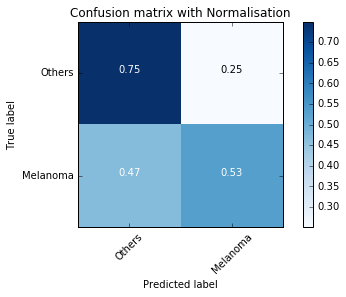

In [49]:
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize= True,
                      name = "Confusion_matrix_with_normalisation.png",
                      title='Confusion matrix with Normalisation')